In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as an
import scanpy as sc

from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

# Read datafiles

In [2]:
data_path = '../SourceData/Figure4/'

sc_ad_recorded = sc.read_h5ad(data_path + 'st_ad_recorded_filtered.h5ad')
ad_ephy = sc.read_h5ad(data_path + 'ad_ephy.h5ad')
ad_local_comp = sc.read_h5ad(data_path + 'ad_local_cell_composition.h5ad')


# Comparing between cell niche (Figure 4a)

## gene

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_5418/85514068.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expression_top['cell_niche'] = cell_niche


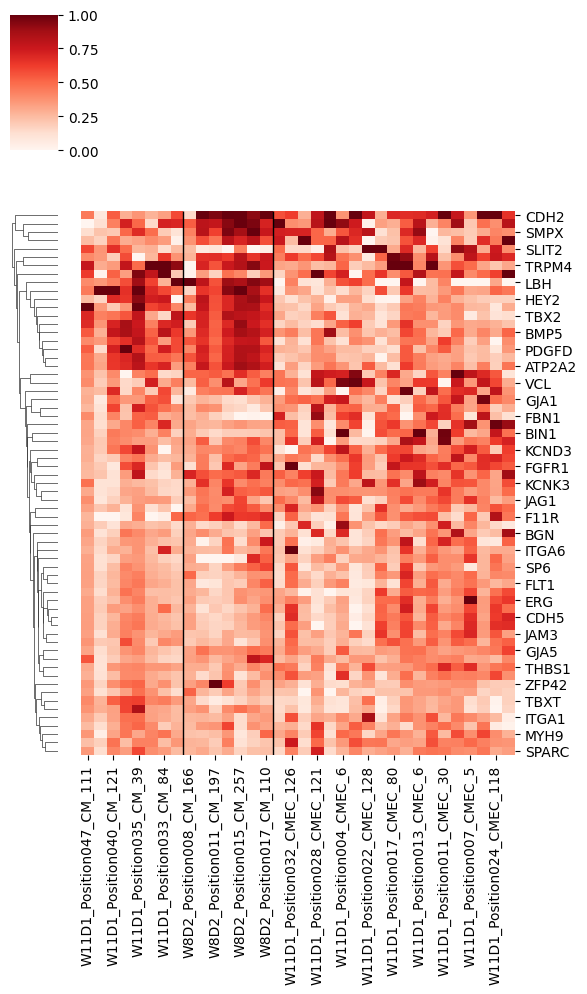

In [3]:
gene_expression = pd.DataFrame(sc_ad_recorded.X, index=sc_ad_recorded.obs.index, columns=sc_ad_recorded.var_names)
cell_niche = sc_ad_recorded.obs['niche']

# Initialize a list to store the statistics
gene_stats = []

# Loop through each gene and perform an ANOVA test across the three cell types
for gene in gene_expression.columns:
    # Get the data for each cell type
    group1 = gene_expression[cell_niche == 'Niche_1'][gene]
    group2 = gene_expression[cell_niche == 'Niche_2'][gene]
    group3 = gene_expression[cell_niche == 'Niche_3'][gene]
    
    # Perform one-way ANOVA (parametric)
    f_stat, p_value = f_oneway(group1, group2, group3)
    
    # Store the gene, test statistic, and p-value
    gene_stats.append({
        'Gene': gene,
        'F-stat': f_stat,
        'p-value': p_value
    })

# Convert results into a DataFrame
gene_stats_df = pd.DataFrame(gene_stats)

# Sort by p-value to rank the genes
ranked_genes = gene_stats_df.sort_values('p-value')

# Select the top 65 genes based on p-value
top_genes = ranked_genes.head(65)['Gene'].tolist()

# Subset the gene expression data to include only the top n genes
gene_expression_top = gene_expression[top_genes]

# Add cell type information to the gene expression data
gene_expression_top['cell_niche'] = cell_niche

# Sort the data by cell type to keep CM1, CM2, and CM3 together
gene_expression_top_sorted = gene_expression_top.sort_values('cell_niche')
gene_expression_top_sorted_data = gene_expression_top_sorted.drop('cell_niche', axis=1)


# Create the clustermap
g = sns.clustermap(gene_expression_top_sorted_data.T, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Reds", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=1, 
                   dendrogram_ratio = (0.1, 0.2),
                   figsize=(6, 10)) 

# Draw lines to separate different cell types (adjust the number and color based on your data)
n_niche_type_1 = (gene_expression_top_sorted['cell_niche'] == 'Niche_1').sum()
n_niche_type_2 = (gene_expression_top_sorted['cell_niche'] == 'Niche_1').sum() + (gene_expression_top_sorted['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_niche_type_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_niche_type_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()


## ephy

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_5418/1756975734.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephy_expression_top['cell_niche'] = cell_niche


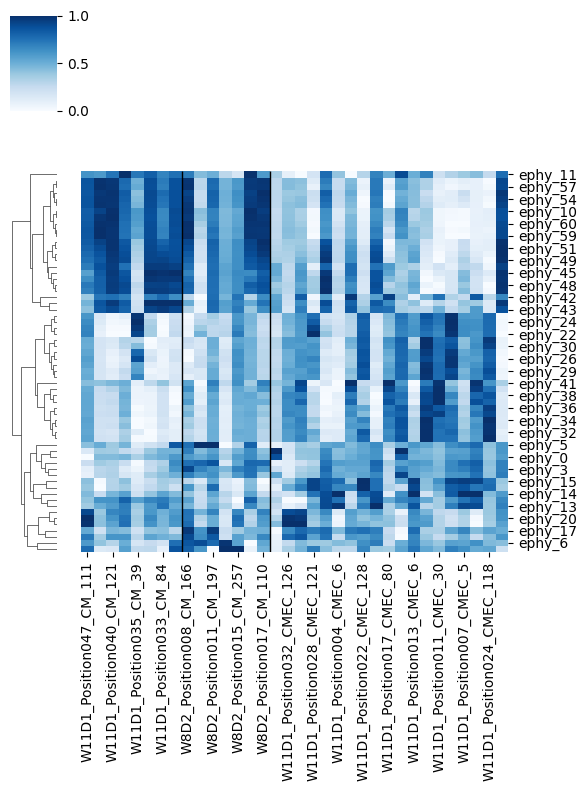

In [4]:
ephy_expression = pd.DataFrame(ad_ephy.X, index=ad_ephy.obs.index, columns=ad_ephy.var_names)
cell_niche = ad_ephy.obs['niche']

# Initialize a list to store the statistics
ephy_stats = []

# Loop through each gene and perform an ANOVA test across the three cell niches
for ephy in ephy_expression.columns:
    # Get the data for each niche
    group1 = ephy_expression[cell_niche == 'Niche_1'][ephy]
    group2 = ephy_expression[cell_niche == 'Niche_2'][ephy]
    group3 = ephy_expression[cell_niche == 'Niche_3'][ephy]
    
    # Perform one-way ANOVA (parametric)
    f_stat, p_value = f_oneway(group1, group2, group3)
    
    # Store the gene, test statistic, and p-value
    ephy_stats.append({
        'Feature': ephy,
        'F-stat': f_stat,
        'p-value': p_value
    })

# Convert results into a DataFrame
ephy_stats_df = pd.DataFrame(ephy_stats)

# Sort by p-value to rank the genes
ranked_features = ephy_stats_df.sort_values('p-value')

# Use all features
top_features = ranked_features['Feature'].tolist()

ephy_expression_top = ephy_expression[top_features]
ephy_expression_top['cell_niche'] = cell_niche

# Sort the data by cell niche
ephy_expression_top_sorted = ephy_expression_top.sort_values('cell_niche')
ephy_expression_top_sorted_data = ephy_expression_top_sorted.drop('cell_niche', axis=1)


# Create the clustermap
g = sns.clustermap(ephy_expression_top_sorted_data.T, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Blues", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=1,  
                   dendrogram_ratio = (0.1, 0.2),
                   figsize=(6, 8)) 

# Draw lines to separate different cell types 
n_niche_type_1 = (ephy_expression_top_sorted['cell_niche'] == 'Niche_1').sum()
n_niche_type_2 = (ephy_expression_top_sorted['cell_niche'] == 'Niche_1').sum() + (ephy_expression_top_sorted['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_niche_type_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_niche_type_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()

## Cell composition

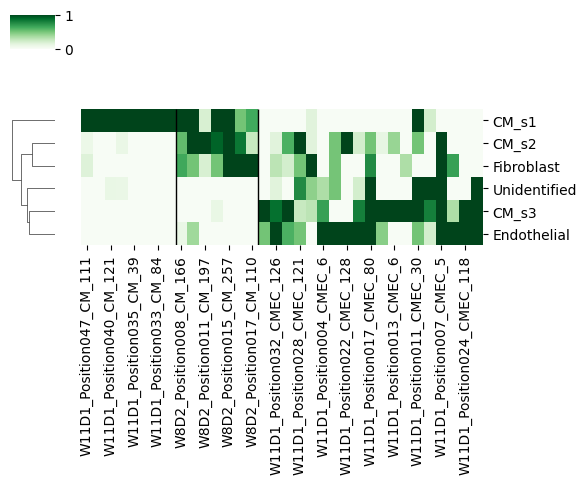

In [5]:
local_comp = pd.DataFrame(ad_local_comp.X, index=ad_local_comp.obs.index, columns=ad_local_comp.var_names)
local_comp['cell_niche'] = ad_local_comp.obs['niche']

# Sort the data by cell type to keep different cell types together
local_comp_sorted = local_comp.sort_values('cell_niche')
local_comp_sorted = local_comp_sorted.drop('cell_niche', axis=1)

# Transpose the data to swap x and y axes
local_composition_data_transposed = local_comp_sorted.T 

# Create the clustermap with reversed axes
g = sns.clustermap(local_composition_data_transposed, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Greens", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=True,  
                   dendrogram_ratio=(0.1, 0.2),
                   figsize=(6, 5)) 

# Draw lines to separate different cell types 
n_cell_niche_1 = (local_comp['cell_niche'] == 'Niche_1').sum()
n_cell_niche_2 = (local_comp['cell_niche'] == 'Niche_1').sum() + (local_comp['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_cell_niche_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_cell_niche_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()

# Electrophysiological properties across Niche_1, Niche_2, and Niche_3

## Calculate pseudotime

In [6]:
# Activate the pandas2ri conversion
pandas2ri.activate()

# Import necessary R packages
base = importr('base')
slingshot = importr('slingshot')

# Step 3: Convert the UMAP embeddings and cluster labels to R-compatible formats
with localconverter(ro.default_converter + pandas2ri.converter):
    umap = ro.conversion.py2rpy(pd.DataFrame(ad_ephy.obsm['X_umap'], index=ad_ephy.obs.index))
    clusters = ro.conversion.py2rpy(pd.Series(ad_ephy.obs['leiden'], index=ad_ephy.obs.index))

# Step 4: Ensure the data is converted to appropriate R types
umap_matrix = ro.r['as.matrix'](umap)
clusters_factor = ro.r['as.factor'](clusters)

# Step 5: Run Slingshot
ro.globalenv['umap'] = umap_matrix
ro.globalenv['clusters'] = clusters_factor
slingshot_results = slingshot.slingshot(umap_matrix, clusterLabels=clusters_factor)

# Step 6: Extract pseudotime for each lineage
pseudotime = ro.r['slingPseudotime'](slingshot_results)

# Step 7: Convert the pseudotime to a pandas DataFrame
with localconverter(ro.default_converter + pandas2ri.converter):
    pseudotime_df = pd.DataFrame(ro.conversion.rpy2py(pseudotime))

# Step 8: Combine pseudotime values by averaging across all lineages
combined_pseudotime = pseudotime_df.mean(axis=1)

# Step 9: Normalize pseudotime values to range [0, 1]
min_pseudotime = combined_pseudotime.min()
max_pseudotime = combined_pseudotime.max()
normalized_pseudotime = (combined_pseudotime - min_pseudotime) / (max_pseudotime - min_pseudotime)

# Step 10: Add normalized pseudotime to AnnData object
ad_ephy.obs['ephy_pseudotime_normalized'] = normalized_pseudotime.values


/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


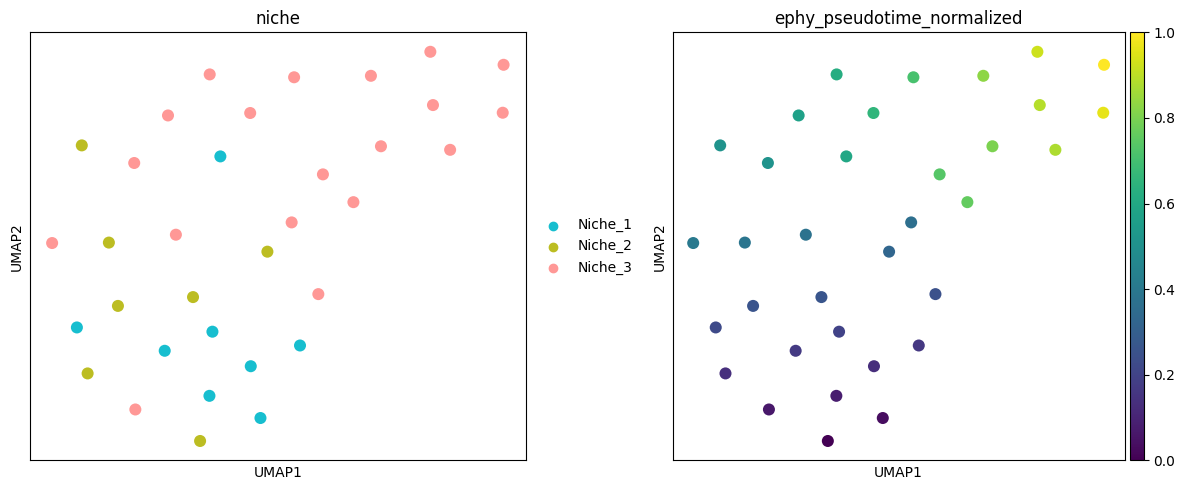

In [7]:
palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5)) 

axs1 = sc.pl.umap(ad_ephy, color=['niche'],palette=palette_niche,  size=300, ax=ax[0], show=False) 
axs2 = sc.pl.umap(ad_ephy, color=['ephy_pseudotime_normalized'], size=300, ax=ax[1], show=False) 

plt.tight_layout()  
plt.show()

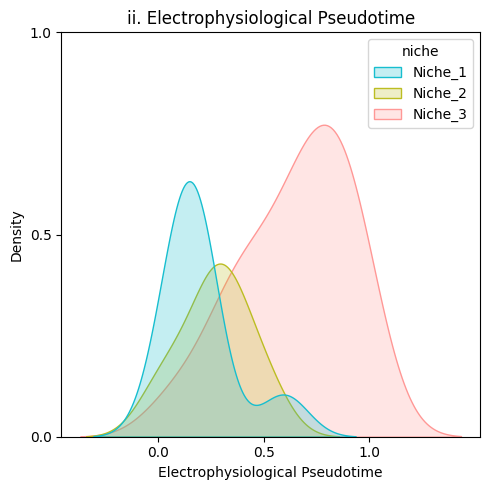

In [8]:
ephy_pseudotime = ad_ephy.obs['ephy_pseudotime_normalized']  
niche = ad_ephy.obs['niche']
palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}

plt.figure(figsize=(5, 5))

plt.subplot(1, 1, 1)
sns.kdeplot(x=ephy_pseudotime, hue=niche, palette=palette_niche, fill=True)


plt.xlabel('Electrophysiological Pseudotime')
plt.ylabel('Density')
plt.xticks([0, 0.5, 1])
plt.yticks([0,0.5,1])
plt.title('ii. Electrophysiological Pseudotime')

plt.tight_layout()
plt.show()

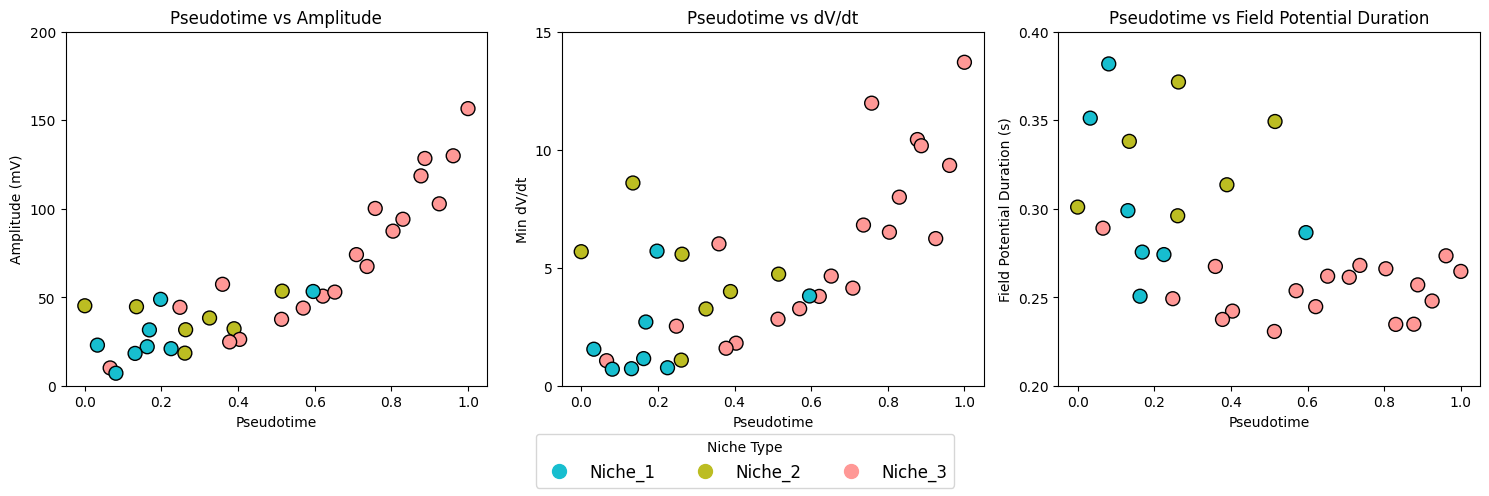

In [9]:
ephy_pseudotime = ad_ephy.obs['ephy_pseudotime_normalized']  # Pseudotime
waveform_amplitude = ad_ephy.uns['Spike Amplitude']          # Amplitude
waveform_dvdt = ad_ephy.uns['Min dVdt']                     # Min dV/dt
waveform_FPD = ad_ephy.uns['Field Potential Duration (s)']   # Field Potential Duration
cell_type = ad_ephy.obs['cell_type']
niche_type = ad_ephy.obs['niche']

# Define a color palette for the niche types
palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}
niche_type_colors = niche_type.map(palette_niche)  # Map niche types to colors

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Pseudotime vs Amplitude
axes[0].scatter(
    ephy_pseudotime, waveform_amplitude, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[0].set_title("Pseudotime vs Amplitude")
axes[0].set_xlabel("Pseudotime")
axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_yticks([0, 50, 100, 150, 200]) 
axes[0].set_ylim(0, 200) 

# Pseudotime vs dV/dt
axes[1].scatter(
    ephy_pseudotime, waveform_dvdt, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[1].set_title("Pseudotime vs dV/dt")
axes[1].set_xlabel("Pseudotime")
axes[1].set_ylabel("Min dV/dt")
axes[1].set_yticks([0, 5, 10, 15])  
axes[1].set_ylim(0, 15)  

# Pseudotime vs FPD
axes[2].scatter(
    ephy_pseudotime, waveform_FPD, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[2].set_title("Pseudotime vs Field Potential Duration")
axes[2].set_xlabel("Pseudotime")
axes[2].set_ylabel("Field Potential Duration (s)")
axes[2].set_yticks([0.2, 0.25, 0.3, 0.35, 0.4]) 
axes[2].set_ylim(0.2, 0.4)  

# Add a legend for niche types
handles = [plt.Line2D([0], [0], marker='o', color=color, label=niche, linestyle='', markersize=10)
           for niche, color in palette_niche.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(palette_niche), fontsize=12, title="Niche Type")

plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.show()